In [27]:
import pandas as pd
import numpy as np
import pickle
import os

from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from matplotlib import pyplot as plt
import matplotlib
import tkinter
# matplotlib.use('TkAgg')
# do the inline thing
%matplotlib inline

import ugtm
from ugtm import eGTM
import altair as alt

from outlier import iqr_method, reorder_cols
from lcfunctions import download_lasair_lc, display_lightcurve
from lcfunctions import lasair_clean, load_lasair_lc

### Put together dataframe to generate dataset.

In [28]:
cvlistdate = '21032023'
lightcurvesdate = '08102023'
label_scheme = 'labels_1'
gaia = False

pd.options.display.max_columns = None

dataset = pd.read_csv(f'../processed_data/dataset_{cvlistdate}allfeatures_inc_labels{lightcurvesdate}.csv', low_memory=False)
dataset = dataset[dataset[label_scheme].notna()].reset_index(drop=True)
# drop rows with no Gaia data
# dataset = dataset[dataset['ra_error'].notna()].reset_index(drop=True)
# dataset = dataset[dataset['absmag_g'].notna()].reset_index(drop=True)

# Drop Gaia features
dataset = dataset.iloc[:,:-34]

# Filter dataset
dataset_pts_threshold = dataset[(dataset['n_obs_g']>=20) | (dataset['n_obs_r']>=20)].reset_index(drop=True)
# dataset_timespan_threshold = dataset[dataset['temporal_baseline_g']>=365].reset_index(drop=True)

# Dataset going forward
dataset_final = dataset_pts_threshold

print(dataset_final[label_scheme].value_counts())

X = dataset_final.iloc[:,14:]
X_cols = X.columns.tolist()
y_names = dataset_final[label_scheme]
enc = LabelEncoder()
y = enc.fit_transform(y_names)


# Handle outliers
cap_cols1 = ['Period_fit_g','Period_fit_r']
cap_cols2 = ['pwr_max_g','pwr_max_r']
cap_cols3 = ['distance']

iqr_cols1 = ['LinearTrend_g','LinearTrend_r']
iqr_cols2 = ['clr_mean','clr_median', 'clr_bright','clr_faint']
iqr_cols3 = ['astrometric_sigma5d_max']
iqr_cols4 = ['bp_rp','bp_g','g_rp']
iqr_cols5 = ['absmag_g','absmag_bp','absmag_rp']

log_cols = ['Autocor_length_g','CAR_mean_g','CAR_sigma_g','Eta_e_g',
            'Freq1_harmonics_amplitude_0_g','Freq1_harmonics_amplitude_1_g',
            'Freq1_harmonics_amplitude_2_g','Freq1_harmonics_amplitude_3_g',
            'Freq2_harmonics_amplitude_0_g','Freq2_harmonics_amplitude_1_g',
            'Freq2_harmonics_amplitude_2_g','Freq2_harmonics_amplitude_3_g',
            'Freq3_harmonics_amplitude_0_g','Freq3_harmonics_amplitude_1_g',
            'Freq3_harmonics_amplitude_2_g','Freq3_harmonics_amplitude_3_g',
            'MaxSlope_g','PeriodLS_g','SlottedA_length_g',
            'Autocor_length_r','CAR_mean_r','CAR_sigma_r','Eta_e_r',
            'Freq1_harmonics_amplitude_0_r','Freq1_harmonics_amplitude_1_r',
            'Freq1_harmonics_amplitude_2_r','Freq1_harmonics_amplitude_3_r',
            'Freq2_harmonics_amplitude_0_r','Freq2_harmonics_amplitude_1_r',
            'Freq2_harmonics_amplitude_2_r','Freq2_harmonics_amplitude_3_r',
            'Freq3_harmonics_amplitude_0_r','Freq3_harmonics_amplitude_1_r',
            'Freq3_harmonics_amplitude_2_r','Freq3_harmonics_amplitude_3_r',
            'MaxSlope_r','PeriodLS_r','SlottedA_length_r'
            ]

log_cols2 = ['freq_pwr_max_g','pwr_maxovermean_g',
             'npeaks_pt5to1_g','rrate_pt5to1_g','drate_pt5to1_g', 
             'npeaks_1to2_g','rrate_1to2_g','drate_1to2_g',
             'npeaks_2to5_g','rrate_2to5_g','drate_2to5_g',
             'npeaks_above5_g','rrate_above5_g','drate_above5_g',
             'rollstd_ratio_t20s10_g','rollstd_ratio_t10s5_g',
             'pnts_leq_rollMedWin20-1mag_g','pnts_leq_rollMedWin20-2mag_g','pnts_leq_rollMedWin20-5mag_g',
             'pnts_geq_rollMedWin20+1mag_g','pnts_geq_rollMedWin20+2mag_g','pnts_geq_rollMedWin20+3mag_g',
             'pnts_leq_median-1mag_g','pnts_leq_median-2mag_g','pnts_leq_median-5mag_g',
             'pnts_geq_median+1mag_g','pnts_geq_median+2mag_g','pnts_geq_median+3mag_g',
             'freq_pwr_max_r','pwr_maxovermean_r',
             'npeaks_pt5to1_r','rrate_pt5to1_r','drate_pt5to1_r',
             'npeaks_1to2_r','rrate_1to2_r','drate_1to2_r',
             'npeaks_2to5_r','rrate_2to5_r','drate_2to5_r',
             'npeaks_above5_r','rrate_above5_r','drate_above5_r',
             'rollstd_ratio_t20s10_r','rollstd_ratio_t10s5_r',
             'pnts_leq_rollMedWin20-1mag_r','pnts_leq_rollMedWin20-2mag_r','pnts_leq_rollMedWin20-5mag_r',
             'pnts_geq_rollMedWin20+1mag_r','pnts_geq_rollMedWin20+2mag_r','pnts_geq_rollMedWin20+3mag_r',
             'pnts_leq_median-1mag_r','pnts_leq_median-2mag_r','pnts_leq_median-5mag_r',
             'pnts_geq_median+1mag_r','pnts_geq_median+2mag_r','pnts_geq_median+3mag_r'
             ]

log_cols3 = ['ra_error','dec_error',
            'parallax_error',
            'pm',
            'pmra_error',
            'pmdec_error',
            'phot_g_mean_flux',
            'phot_g_mean_flux_error',
            'phot_bp_mean_flux',
            'phot_bp_mean_flux_error',
            'phot_rp_mean_flux',
            'phot_rp_mean_flux_error',
            'distance'
            ]


log_transformer1 = FunctionTransformer(np.log1p, validate=False)
log_transformer2 = FunctionTransformer(np.log1p, validate=False)
log_transformer3 = FunctionTransformer(np.log1p, validate=False)

cap_transformer1 = FunctionTransformer(np.clip, validate=False, kw_args={'a_min':0, 'a_max':1})
cap_transformer2 = FunctionTransformer(np.clip, validate=False, kw_args={'a_min':0, 'a_max':1})
cap_transformer3 = FunctionTransformer(np.clip, validate=False, kw_args={'a_min':0, 'a_max':np.inf})

iqr_transformer1 = FunctionTransformer(iqr_method, validate=False, kw_args={'factor': 5})
iqr_transformer2 = FunctionTransformer(iqr_method, validate=False, kw_args={'factor': 2})
iqr_transformer3 = FunctionTransformer(iqr_method, validate=False, kw_args={'factor': 10})
iqr_transformer4 = FunctionTransformer(iqr_method, validate=False, kw_args={'factor': 2})
iqr_transformer5 = FunctionTransformer(iqr_method, validate=False, kw_args={'factor': 3})


if gaia == True:
    preprocessor = ColumnTransformer(
        transformers=[
            ('cap', cap_transformer1, cap_cols1),
            ('cap2', cap_transformer2, cap_cols2),
            ('cap3', cap_transformer3, cap_cols3),
            ('iqr1', iqr_transformer1, iqr_cols1),
            ('iqr2', iqr_transformer2, iqr_cols2),
            ('iqr3', iqr_transformer3, iqr_cols3),
            ('iqr4', iqr_transformer4, iqr_cols4),
            ('iqr5', iqr_transformer5, iqr_cols5),
            ('log_transform1', log_transformer1, log_cols),
            ('log_transform2', log_transformer2, log_cols2),
            ('log_transform3', log_transformer3, log_cols3)
        ],
        remainder='passthrough',  # Pass through columns not specified in transformers
        verbose_feature_names_out=False).set_output(transform='pandas'
    )
elif gaia == False:
    preprocessor = ColumnTransformer(
        transformers=[
            ('cap', cap_transformer1, cap_cols1),
            ('cap2', cap_transformer2, cap_cols2),
            ('iqr1', iqr_transformer1, iqr_cols1),
            ('iqr2', iqr_transformer2, iqr_cols2),
            ('log_transform1', log_transformer1, log_cols),
            ('log_transform2', log_transformer2, log_cols2)
        ],
        remainder='passthrough',  # Pass through columns not specified in transformers
        verbose_feature_names_out=False).set_output(transform='pandas'
    )


labels_1
dwarf_nova_SU_UMa    378
dwarf_nova_Z_Cam     168
nova_like            138
nova_like_VY_Scl     117
dwarf_nova_U_Gem     115
polar                110
int_polar             49
AMCVn                 35
dwarf_nova_WZ_Sge     32
nova                  27
dwarf_nova_ER_UMa     25
Name: count, dtype: int64


/Users/aridmist/opt/anaconda3/envs/ugtm/lib/python3.10/site-packages/sklearn/preprocessing/_function_transformer.py:345: UserWarning: With transform="pandas", `func` should return a DataFrame to follow the set_output API.
  warnings.warn(


In [177]:
# enc = LabelEncoder().fit(y_names)
# y = enc.transform(y_names)

# # Train, test, split.
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=1)

# # Scale data.
# scaler = StandardScaler()
# X_train_proc = scaler.fit_transform(X_train)
# X_test_proc = scaler.transform(X_test)
# scaler2 = StandardScaler()
# X_proc = scaler2.fit_transform(X)

# # Impute missing values with knn imputer.
# imputer = KNNImputer(n_neighbors=5)
# X_train_proc = imputer.fit_transform(X_train_proc)
# X_test_proc = imputer.transform(X_test_proc)
# imputer2 = KNNImputer(n_neighbors=5)
# X_proc = imputer2.fit_transform(X_proc)

# # Standard scale again
# scaler3 = StandardScaler()
# X_train_proc = scaler3.fit_transform(X_train_proc)
# X_test_proc = scaler3.transform(X_test_proc)
# scaler4 = StandardScaler()
# X_proc = scaler4.fit_transform(X_proc)


### eGTM: GTM transformer

eGTM is a sklearn-compatible GTM transformer. Similarly to PCA or t-SNE, eGTM reduces the dimensionality from n_dimensions to 2 dimensions. To generate mean GTM 2D projections:

In [29]:
import ugtm

k=12
gtm_model_sklearn = eGTM(k=k, niter=10000, model='means', random_state=77)

scaler2 = StandardScaler()
imputer2 = KNNImputer(n_neighbors=5)

pipeline_sklearn = Pipeline([
    ('preprocessor', preprocessor),
    ('reorder_cols', FunctionTransformer(reorder_cols, kw_args={'cols':X_cols})),
    ('scaler', scaler2),
    ('imputer', imputer2),
    ('gtm', gtm_model_sklearn)
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('reorder_cols', FunctionTransformer(reorder_cols, kw_args={'cols':X_cols})),
    ('scaler', scaler2),
    ('imputer', imputer2),
])

gtm_model_input = pipeline.fit_transform(X)
gtm_model = ugtm.runGTM(data=gtm_model_input, k=k, niter=10000, doPCA=False, missing=False, random_state=77)

# k=16, m=4, s=0.3, regul=0.1, random_state=1234, niter=200, verbose=False, model='means'



# # Fit and transform the data using the pipeline

pipeline_sklearn.fit(X)

# Save the pipeline
import pickle
if gaia == True:
    with open(f'../results/model/model_gtm_cvlist{cvlistdate}_lcdata{lightcurvesdate}_withgaia.pkl', 'wb') as f:
        pickle.dump(pipeline, f)
elif gaia == False:
    with open(f'../results/model/model_gtm_cvlist{cvlistdate}_lcdata{lightcurvesdate}_lconly.pkl', 'wb') as f:
        pickle.dump(pipeline, f)


# X_gtm = pipeline_sklearn.transform(X)

# Fit GTM on X_train and get 2D projections for X_test
# model1 = eGTM(k=k).fit(X_train_proc)
             
# X_train_gtm = model1.transform(X_train_proc)
# X_test_gtm = model1.transform(X_test_proc)

# a = pipeline.transform(X)


/Users/aridmist/opt/anaconda3/envs/ugtm/lib/python3.10/site-packages/altair/utils/deprecation.py:65: AltairDeprecationWarning: 'selection_multi' is deprecated.  Use 'selection_point'
  warnings.warn(message, AltairDeprecationWarning, stacklevel=1)


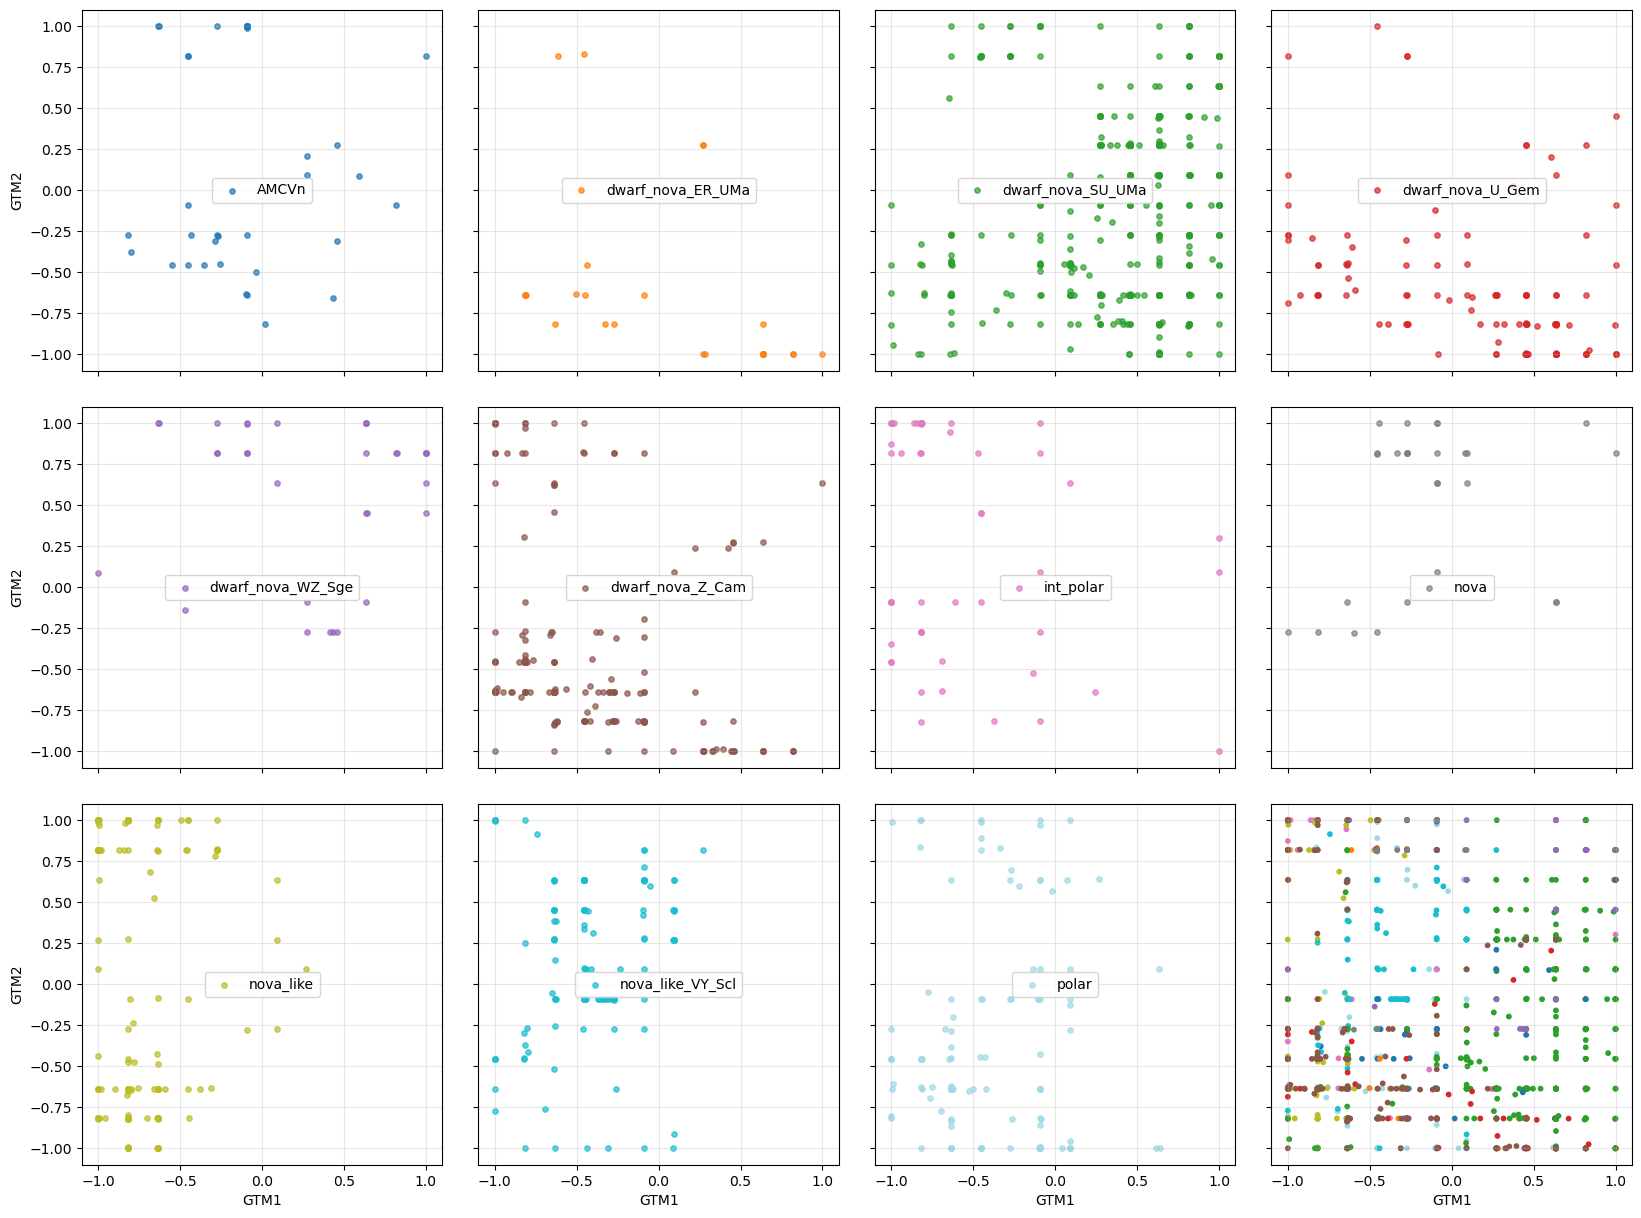

alt.Chart(...)

In [31]:
size = 30

mean_u = gtm_model.matMeans
modes_u = gtm_model.matModes
X_gtm = mean_u

df_gtm_X = pd.DataFrame(mean_u, columns=['GTM1','GTM2'])

df_gtm_X = pd.concat([df_gtm_X, 
                      pd.Series(dataset_final.index, name='index'), 
                      dataset_final['oid_ztf'], 
                      dataset_final['type_aavso'],
                      pd.Series(y_names, name='label'),
                      pd.Series(mean_u[:,0], name='mode1'),
                      pd.Series(mean_u[:,1], name='mode2')
                      ], axis=1)

selection = alt.selection_multi(fields=['label'], bind='legend')

projection_full = alt.Chart(df_gtm_X).mark_square().encode(
    x='GTM1',y='GTM2',
    color=alt.Color(shorthand='label', title='Class',
                    # Select a colour scheme for the classes where the colours are distinct, and more than 11 classes
                    scale=alt.Scale(domain=np.unique(y_names).tolist(),
                                    scheme='category20',
                                    # range=clr_range
                                    )),
    # shape='labels',
    size=alt.value(size),
    tooltip=["label", "index", "oid_ztf", "type_aavso"],
    opacity=alt.condition(selection, alt.value(0.8), alt.value(0.1))
    ).add_params(selection
    ).properties(title="GTM projection of X").interactive()

# # use alt.Chart to plot the 2D projections
# df_gtm_train = pd.DataFrame(X_train_gtm, columns=['GTM1', 'GTM2'])
# df_gtm_train['label'] = enc.inverse_transform(y_train)
# projection_train = alt.Chart(df_gtm_train).mark_square().encode(
#     x='GTM1',y='GTM2',
#     color='label',
#     # shape='labels',
#     size=alt.value(size),
#     tooltip=["label"],
#     opacity=alt.condition(selection, alt.value(0.8), alt.value(0.1))
#     ).add_params(selection
#     ).properties(title="GTM projection of X_train").interactive()

# df_gtm_test = pd.DataFrame(X_test_gtm, columns=['GTM1', 'GTM2'])
# df_gtm_test['label'] = enc.inverse_transform(y_test)
# projection_test = alt.Chart(df_gtm_test).mark_square().encode(
#     x='GTM1',y='GTM2',
#     color='label',
#     # shape='labels',
#     size=alt.value(size),
#     tooltip=["GTM1", "GTM2", "label"],
#     opacity=alt.condition(selection, alt.value(0.8), alt.value(0.1))
#     ).add_params(selection
#     ).properties(title="GTM projection of X_test").interactive()


# Use matplotlib subplots to plot one class versus the rest for each of the classes, where the last subplot is all the classes.
fig, ax = plt.subplots(3,4, figsize=(20,15), sharex=True, sharey=True)
ax = ax.flatten()
# use the cmap tab20 for the first 11 classes
c = plt.cm.tab20(np.linspace(0,1,11))
# can you perform the above as a list of colours from tab20?

for i in range(11):
    # use the color keyword argument to set the colour of the points instead of c
    ax[i].scatter(X_gtm[y==i,0], X_gtm[y==i,1], label=enc.inverse_transform([i])[0], s=15, color=c[i], alpha=0.7)
    ax[i].scatter(X_gtm[y!=i,0], X_gtm[y!=i,1], c='grey', s=30, alpha=0.001)
    ax[i].grid(alpha=0.3)
    if i in [0,4,8]:
        ax[i].set_ylabel(f'GTM2')
    if i in [8,9,10,11]:
        ax[i].set_xlabel(f'GTM1')
    ax[i].legend()
# Use the class colours for the last subplot
ax[11].scatter(X_gtm[:,0], X_gtm[:,1], s=10, alpha=1, c=y, cmap='tab20')
ax[11].set_xlabel(f'GTM1')
ax[11].grid(alpha=0.3)
# reduce the gaps between subplots
plt.subplots_adjust(hspace=0.1, wspace=0.1)
# plt.tight_layout()
plt.show()

projection_full
# alt.hconcat(projection_full, projection_train, projection_test)

In [25]:
# Each example in data space is asociated with a location in 2D space. The mapping depends on using either
# matMeans, or matModes. For example if a dataspace example is associated with a particular node, the mean position
# or median position of the datapoints associated with that Gaussian are used to map it to a point in 2D space. During training,
# the Gaussian center is alocated a position in data space based on the mean or median of points associated with it based on 
# responsibility. It is this mean or median that is used in combination with the wieghted contributions of all Gaussians
# that is used to to map the data point to 2D space. Subsequently, we can create a histogram of locations of each example in 2D space. Therefore,
# matMeans and matModes contains the positions of example in 2D space. 
# Create a 2D histogram, H contains the histogram values in a 2D array, this can be used to generate our plot with altair.
# This is like the number of examples associated with each cluster.

H, xedges, yedges = np.histogram2d(gtm_model.matMeans[:,0],gtm_model.matMeans[:,1],[k,k])
print(H.shape)
# %%
dfmap = pd.DataFrame(gtm_model.matX, columns=["x1", "x2"])
dfmap['size'] = H.flatten()

alt.Chart(dfmap).mark_square().encode(
    x='x1',
    y='x2',
    # color=alt.Color('label:Q',
    #                scale=alt.Scale(scheme='viridis')),
    size='size',
    tooltip=['x1','x2','size'],
    #opacity='density'
).properties(title = "GTM Membership Map",width = 300, height = 300)

(12, 12)


alt.Chart(...)

### Construct reference maps

In [26]:
# matY has shape n_dimensions (number of features) * n_nodes in latent space. 
# Manifold in n-dimensional space (projection of matX in data space); 
# A point matY[:,i] is a center of a Gaussian component i on the manifold in data space. Y=WΦT
# Location of each node in the high dimensional space.
# It is related to the actual probability space through Y=W*phi(transpose).
# We therefore need to normalise the matrix to show the strength of a node's association to a given class relative to the other nodes.


refvect = gtm_model.matY

refvect = MinMaxScaler().fit_transform(refvect.T).T
# refvect = scaler2.inverse_transform(refvect.T).T


# Here we are plotting matX, the coordinates of the nodes in the 2D space. We will colour code them based on 'label'. So this will be a
# grid of pixels in 2D space that is colour coded by some parameter.
def plot_ref_vect(gtm_matX,label,title,fig_size=(100,100)):
    dfmap = pd.DataFrame(gtm_matX, columns=["x1", "x2"])
    dfmap['label'] = label
    map = alt.Chart(dfmap).mark_square().encode(
        x=alt.X('x1'),#, axis=None),
        y=alt.Y('x2'),#, axis=None),
        color=alt.Color('label:Q',
                        #scale=alt.Scale(scheme='viridis')),
                        scale=alt.Scale(scheme='turbo')),
        size=alt.value(75),
        tooltip=['x1','x2', 'label:Q'],
        #opacity='density'
    ).properties(title = alt.TitleParams(text=[title[0:17],title[17:34]], fontSize=12), width = fig_size[0], height = fig_size[1])
    
    return map
# %%


varnames = X_cols[0:]

# Plot individual features along with histogram
# varnames = ['clr_mean']
# dataset_final[varnames].hist(bins=100)

var = 0

# %%
chart = alt.vconcat()
new_line = '\n'
for rr in range(100):
    row = alt.hconcat().resolve_scale(y='shared')
    for cc in range(6):
        if var<len(varnames):
            row |= plot_ref_vect(
                gtm_matX=gtm_model.matX,
                label=refvect[var,:], 
                title=varnames[var])
            var = var + 1
    chart &= row

chart.configure_axis(labelFontSize=0, titleFontSize=0, titleFontWeight='normal')



alt.VConcatChart(...)

In [14]:
from sklearn.preprocessing import minmax_scale

def factor_map(gtm_model, Xfact):
    # Generate a dataframe where the first column is the feature value
    dfclus = pd.DataFrame(Xfact).rename({Xfact.name: 'scale'}, axis=1)
    # matR contains the responsibilities - the posterior probability that a data point
    # belongs to a particular Gaussian - the probability that that Gaussian is responsible for
    # the data point. It has dimensions n_examples x n_nodes.
    # We difine in the membership column the node most responsible for the data point.
    dfclus['membership'] = np.argmax(gtm_model.matR,axis=1)
    # Now group examples by their membership node and then combine the feature values 
    # for each node using their mean value.
    dfclus = dfclus.groupby('membership', as_index=False).agg(np.mean)
    # Now scale the grouped and meaned feature values from 0 to 1.
    dfclus.scale = minmax_scale(dfclus.scale)
    # We now use matX which contains the location in 2D space of all our neurons.
    # This is just a 2D grid. Place in a dataframe.
    df_map = pd.DataFrame(gtm_model.matX, columns=["x1", "x2"])
    # Now assign to each node its node number. This is the node memebership number
    # to which each example was assigned earlier. Some nodes were associated with examples,
    # others were not because examples had greater associations with other Gaussians.
    df_map['membership'] = np.arange(0,144)
    # We now wish to merge the above dataframes to produce a grid on neurons (coordinate values), each one with
    # the mean value of the feature for the examples associated with that neuron (Gaussian).
    df_map = df_map.merge(dfclus,how='left',on='membership')
    # Those nodes without any assigned examples will be given a value of 0
    # df_map.fillna(0,inplace=True)
    # size column is added to assign the size of the square in the plot.
    df_map['size'] = 1
    return df_map

def plot_factor_map(df_map, title='Factor Map',fig_size=(150,150),node_size=1):
    df_map = pd.concat([df_map, 
                       pd.Series(dataset_final.index, name='index'), 
                       dataset_final['oid_ztf'], 
                       dataset_final['type_aavso'],
                       pd.Series(y_names, name='label')
                       ], axis=1)
    #df_map['size']=df_map['size']*node_size
    return alt.Chart(df_map).mark_square().encode(
        x=alt.X('x1',axis=None),
        y=alt.Y('x2',axis=None),
        color=alt.Color('scale:Q',
                        scale=alt.Scale(scheme='turbo')),
        size=alt.value(150),
        tooltip=['index', 'label', 'oid_ztf', 'type_aavso','scale:Q'],
        #opacity='density'
    ).properties(title=title, width=fig_size[0], height=fig_size[1])

In [96]:
varnames = X_cols[0:5]
gtm_model_for_plot = gtm_model # transformed, gtm_model
df_gtm_X
# X_set = X_test_fnl # X_train_fnl, X_test_fnl, X_train_imp
# varnames = selected
var = 0

# %%
chart = alt.vconcat()
new_line = '\n'
for rr in range(100):
    row = alt.hconcat()
    for cc in range(5):
        if var<len(varnames):
            idx_X_set = X_cols.index(varnames[var])
            row |= plot_factor_map(
                factor_map(gtm_model_for_plot, pd.DataFrame(X_proc).iloc[:,idx_X_set]),
                title=[varnames[var][0:17], varnames[var][17:34]])
            var = var + 1
    chart &= row

chart




alt.VConcatChart(...)

### Inspect examples assigned to each node

In [152]:
mode2_values = df_gtm_X.mode2.value_counts().index.tolist()
mode1_values = df_gtm_X.mode1.value_counts().index.tolist()
mode1_values.sort()
mode2_values.sort()

node_x = 7
node_y = 0
node_df = df_gtm_X[(df_gtm_X['mode1']==mode1_values[node_x]) & (df_gtm_X['mode2']==mode2_values[node_y])]
node_examples = node_df['oid_ztf'].to_list()
print(node_examples)
projection_full

['ZTF18abryuah', 'ZTF18abgjgiq', 'ZTF18absgnqy', 'ZTF18abcrbmk', 'ZTF18abwiccd', 'ZTF17aacbuuj', 'ZTF17aadnfyi', 'ZTF17aaairls', 'ZTF18abcoxgp', 'ZTF18abcqzxh', 'ZTF18abotfmi', 'ZTF18aavooiu', 'ZTF17aaaslvp', 'ZTF17aabxhpg', 'ZTF18acdxcix', 'ZTF18aabhjpn', 'ZTF18aaldbxd']


alt.Chart(...)

In [154]:
# Display lasair difference magnitude and apparent magnitude light curves.
index = 942
# objects = [dataset_final.iloc[index,:]['oid_ztf']]
objects = node_examples

date = '08102023'

# Apply errorbars
error = False

if error == True:
        errColalerce1 = 'sigmapsf'
        errColalerce2 = 'sigmapsf_corr_revised'
        errCollasair1 = 'sigmapsf'
        errCollasair2 = 'dc_sigmag'
else:
    errColalerce1 = None
    errColalerce2 = None
    errCollasair1 = None
    errCollasair2 = None

for object in objects:
    manual_label = dataset_final[dataset_final['oid_ztf']==object]['labels_1'].values[0]
    oid_aavso = dataset_final[dataset_final['oid_ztf']==object]['oid_aavso'].values[0]
    type_aavso = dataset_final[dataset_final['oid_ztf']==object]['type_aavso'].values[0]
    print(object, manual_label, oid_aavso, type_aavso)
    try:
        lc_lasair = load_lasair_lc(object, path=f'../lightcurves_dataset/lasair_{date}')
    except:
        # Create a folder within path for LCs if one does not exist
        if not os.path.exists(f'../lightcurves_dataset/lasair_non_dataset/cache'):
            os.makedirs(f'../lightcurves_dataset/lasair_non_dataset/cache')
        print('Not in dataset')
        download_lasair_lc([object], folderpath=f'../lightcurves_dataset/lasair_non_dataset', cache=f'../lightcurves_dataset/lasair_non_dataset/cache')
        lc_lasair = load_lasair_lc(object, path=f'../lightcurves_dataset/lasair_non_dataset')

    lc_lasair_appmag = lasair_clean(lc_lasair, limit=25, magerrlim=1)

    # print('Lasair difference magnitude')
    # display_lightcurve(lc_lasair,x='jd',y='magpsf',errorCol=errCollasair1)
    print('Lasair apparent magnitude')
    display_lightcurve(lc_lasair_appmag,x='jd',y='dc_mag',errorCol=errCollasair2)

ZTF18abryuah polar ASASSN-19dp AM
Lasair apparent magnitude


ZTF18abgjgiq polar MGAB-V3453 AM
Lasair apparent magnitude


ZTF18absgnqy polar V0358 Aqr AM
Lasair apparent magnitude


ZTF18abcrbmk polar Gaia19cvs AM
Lasair apparent magnitude


ZTF18abwiccd polar Swift J2341.0+7645 AM
Lasair apparent magnitude


ZTF17aacbuuj polar 1RXS J073346.0+261933 AM
Lasair apparent magnitude


ZTF17aadnfyi polar SDSS J074500.58+332859.6 AM
Lasair apparent magnitude


ZTF17aaairls polar MGAB-V410 AM
Lasair apparent magnitude


ZTF18abcoxgp polar V0388 Peg AM
Lasair apparent magnitude


ZTF18abcqzxh polar Swift J2319.4+2619 AM
Lasair apparent magnitude


ZTF18abotfmi polar PT Per AM
Lasair apparent magnitude


ZTF18aavooiu polar V0519 Ser AM
Lasair apparent magnitude


ZTF17aaaslvp polar AI Tri AM
Lasair apparent magnitude


ZTF17aabxhpg polar AN UMa AM+E
Lasair apparent magnitude


ZTF18acdxcix nova_like_VY_Scl MGAB-V3732 NL/VY
Lasair apparent magnitude


ZTF18aabhjpn nova_like_VY_Scl RSMR 1 NL/VY
Lasair apparent magnitude


ZTF18aaldbxd nova_like_VY_Scl BMAM-V788 NL/VY+E
Lasair apparent magnitude
